In [41]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sc
from pylab import plot, log10, linspace, axis
from spectrum import *

In [2]:
def crossSpectrum_Welsh(x, y, nperseg=500, overlap=250, window='hann', padding = False, aggregate='mean', mode = "scipy", f_sample = None, f=None):

    if f_sample is not None and f is not None:
        l = f * nperseg / f_sample
    D = nperseg - overlap
    L = nperseg
    N = len(x)
    if padding and (N - L) % D != 0:
        # Zero padding
        overflow = ((N-L)//D+1)*D + L - N
        x = np.append(x, np.zeros(overflow))
        y = np.append(y, np.zeros(overflow))

    cross = []
    ind = 0
    K = 0

    if window == 'hann':
        window = signal.windows.hann(L)
    elif window == 'hamming':
        window = signal.windows.hamming(L)
    elif window == 'blackman':
        window = signal.windows.blackman(L)
    else:
        window = signal.windows.boxcar(L)

    U = np.sum(window**2) / L
    
    while ind + L <= len(x):

        xp = x[ind : ind + L] 
        yp = y[ind : ind + L] 
        xp = sc.signal.detrend(xp, type='constant')
        yp = sc.signal.detrend(yp, type='constant')

        # Do FFT
        if mode == "scipy":
            cfx = sc.fft.fft(xp * window / L)
            cfy = sc.fft.fft(yp * window / L)
        if mode == "manual":
            exp_vector = np.exp(-2j * np.pi * np.arange(L) * l / L)
            cfx = np.dot(xp * window / L, exp_vector)
            cfy = np.dot(yp * window / L, exp_vector)

        # Get cross spectrum
        cross.append(cfx.conj()*cfy)

        ind += D
        K += 1
    
    cross = np.array(cross) 

    if aggregate == "mean":
        cross = np.mean(cross, axis=0)
    elif aggregate == "median":
        cross = np.median(cross, axis=0)
    elif aggregate == "max":
        cross = np.max(cross, axis=0)
    
    return cross

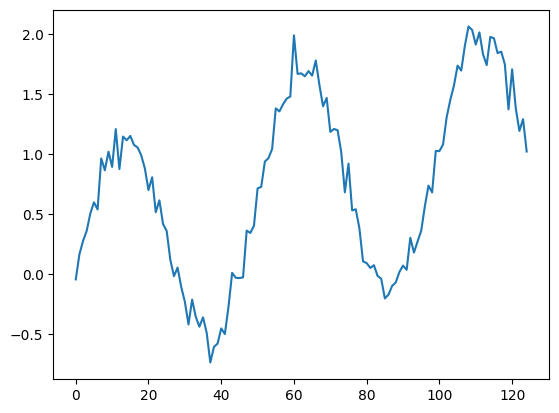

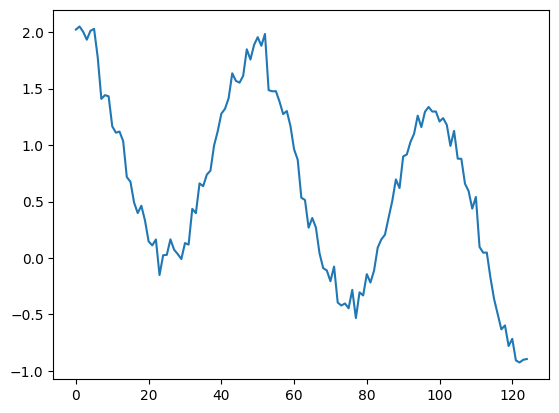

In [31]:
t = np.linspace(0, 250*10**(-3), 125)
f_s = 1/(t[1] - t[0])
x = np.zeros(125)
y = np.zeros(125)
x += np.sin(2*np.pi*t) + np.sin(20*np.pi*t)
x += np.random.normal(0, 0.1, 125)
y += np.cos(2*np.pi*t) + np.cos(20*np.pi*t)
y += np.random.normal(0, 0.1, 125)
plt.plot(x)
plt.show()
plt.plot(y)
plt.show()

[ 5 14 16 18  6 24  0 23  2  1]


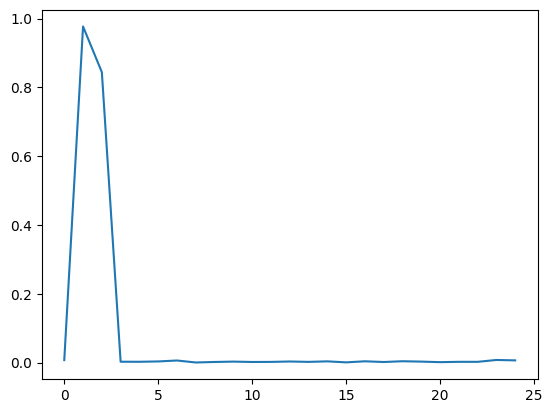

In [39]:
nperseg = 50
noverlap = 25
Pxy = crossSpectrum_Welsh(x, y, nperseg=nperseg, overlap=noverlap, window='hann', padding = False, aggregate='mean', mode = "scipy", f_sample = f_s, f=5)

Pxx = crossSpectrum_Welsh(x, x, nperseg=nperseg, overlap=noverlap, window='hann', padding = False, aggregate='mean', mode="scipy", f_sample = f_s, f=5)

Pyy = crossSpectrum_Welsh(y, y, nperseg=nperseg, overlap=noverlap, window='hann', padding = False, aggregate='mean', mode="scipy", f_sample = f_s, f=5)

coh = np.abs(Pxy)/np.sqrt(np.abs(Pxx)*np.abs(Pyy)+1e-4)
plt.plot(coh[:len(coh)//2])
print(np.argsort(coh[:len(coh)//2])[-10:])

## Coherence with Burg

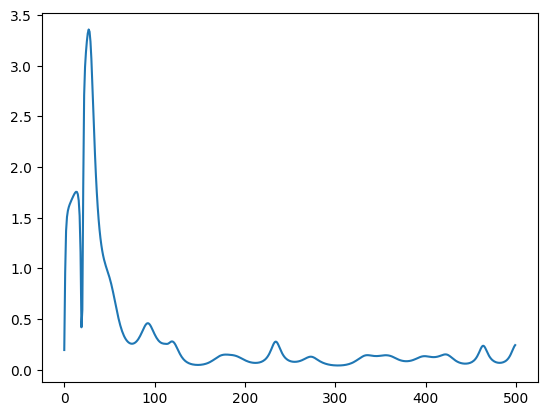

[22 31 23 30 24 29 25 26 28 27]


In [53]:
X = np.concatenate((x, y))
AR, P, k = arburg(x, 30)
PSDx = arma2psd(AR,T=500, NFFT=1000)
AR, P, k = arburg(y, 30)
PSDy = arma2psd(AR,T=500, NFFT=1000)
AR, P, k = arburg(X, 30)
PSDX = arma2psd(AR,T=500, NFFT=1000)
coh = np.abs(PSDX)/np.sqrt(np.abs(PSDx)*np.abs(PSDy)+1e-4)

plt.plot(coh[:len(PSDX)//2])
plt.show()

print(np.argsort(coh[:len(PSDX)//2])[-10:])


12.0

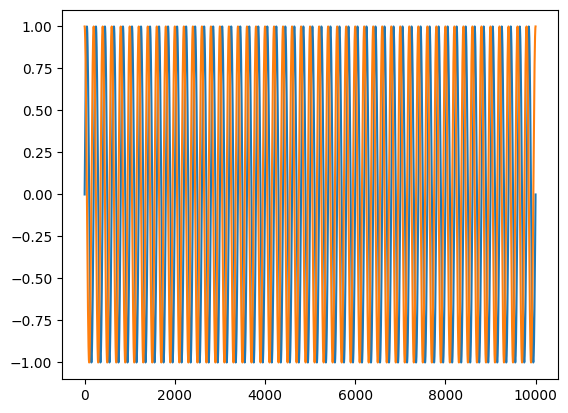

(10000,)
0
[ 0.          1.61317205  1.57106209  1.57065431  1.57121775  1.57271186
  1.57474451  1.57704593  1.5794665   1.58192968  1.58439856  1.58685692
  1.58929912  1.59172478  1.59413615  1.59653659  1.59892994  1.60132011
  1.60371091  1.60610603  1.60850895  1.61092301  1.6133514   1.61579718
  1.61826335  1.62075281  1.62326842  1.62581305  1.62838954  1.63100077
  1.63364966  1.63633919  1.63907241  1.64185248  1.64468266  1.64756634
  1.65050706  1.65350854  1.65657468  1.65970957  1.66291755  1.66620321
  1.66957142  1.67302736  1.67657654  1.68022485  1.68397859  1.68784452
  1.69182988  1.69594248  1.70019071  1.70458365  1.70913111  1.71384374
  1.71873307  1.72381166  1.72909319  1.73459262  1.74032629  1.74631213
  1.75256985  1.75912116  1.76599     1.77320289  1.78078923  1.7887817
  1.79721677  1.80613519  1.81558265  1.82561052  1.83627675  1.84764687
  1.85979529  1.87280669  1.88677785  1.90181969  1.9180598   1.93564544
  1.95474714  1.97556301  1.99832385  2.0

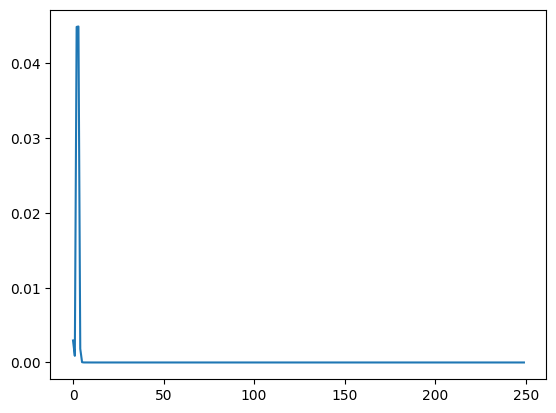

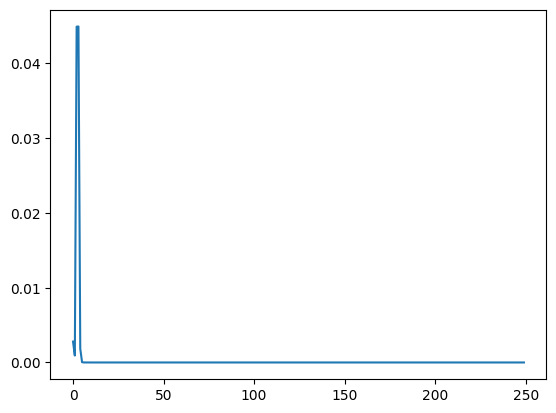

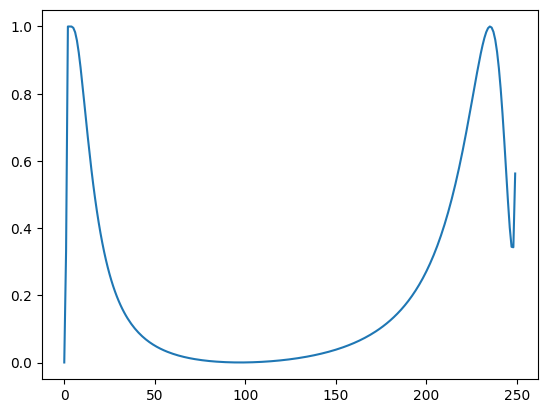

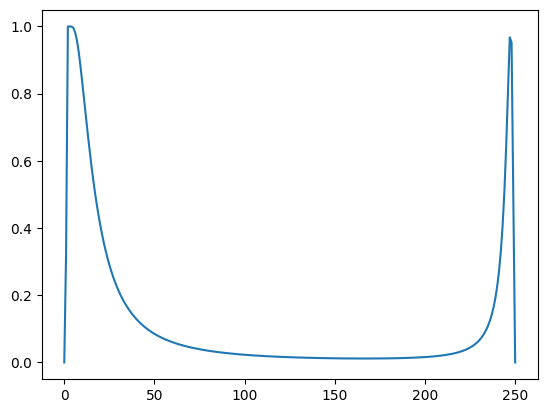

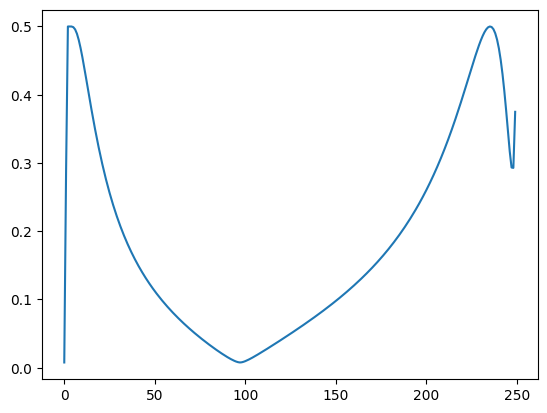

In [13]:
plt.plot(x)
plt.plot(y)
plt.show()

nperseg = 500
overlap = 250

Pxy = crossSpectrum_Welsh(x, y, nperseg = nperseg, overlap = overlap, window="hann", aggregate='mean')
Pxx = crossSpectrum_Welsh(x, x, nperseg = nperseg, overlap = overlap, window="hann", aggregate='mean')
Pyy = crossSpectrum_Welsh(y, y, nperseg = nperseg, overlap = overlap, window="hann", aggregate='mean')
plt.plot(Pxx[:len(Pxx)//2])
plt.show()
plt.plot(Pyy[:len(Pyy)//2])
plt.show()
coh = np.abs(Pxy)**2 / (Pxx * Pyy)
plt.plot(coh[:len(coh)//2])
plt.show()
coh = signal.coherence(x, y, nperseg=nperseg, noverlap=overlap)
plt.plot(coh[1])
plt.show()
coh = np.abs(Pxy) / (Pxx + Pyy)
plt.plot(coh[:len(coh)//2])
plt.show()

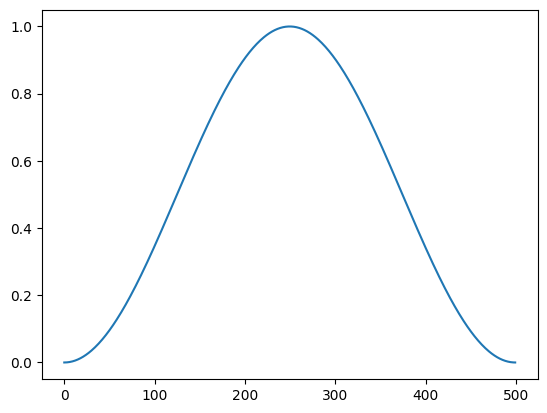

In [39]:
plt.plot(signal.windows.hann(500))

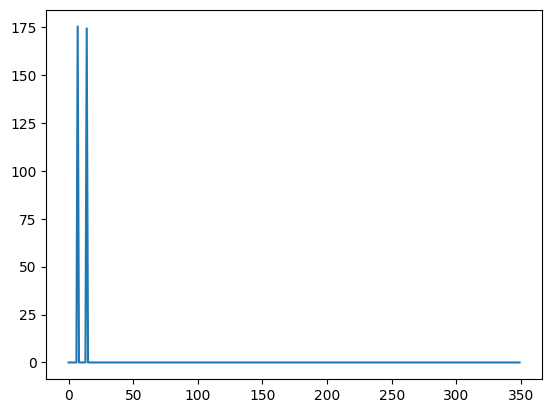

In [48]:
t = np.linspace(0, 1, 1000)
x = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
Pxx = crossSpectrum_Welsh(x, x, nperseg = 700, overlap = 250, window=None, aggregate='mean')
plt.plot(Pxx[:len(Pxx)//2])
plt.show()